In [ ]:
# ====================================================
# Évaluation et entraînement de l'agent AlphaGo/AlphaZero sur Othello
# ====================================================

import sys
sys.path.append('./src')

# Bibliothèques générales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from tqdm.notebook import tqdm
import torch
import pygame
import os
import gymnasium as gym

# Import des modules spécifiques au projet
from Agents.alpha_zero.model import SimpleAlphaZeroNet
from Agents.alpha_zero.mcts_alpha_zero import MCTSAgent
from Env.env import OthelloEnv
from Agents.alpha_zero.train import train_loop

# Définir une graine aléatoire pour la reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# -------------------------------
# below code taken from main 
# -------------------------------

In [9]:
# -------------------------------
# Définition de l'agent aléatoire
# -------------------------------
import random
from tqdm.notebook import tqdm
from Env.env import OthelloEnv, BOARD_SIZE, BLACK, WHITE

class RandomAgent:
    def __init__(self):
        self.name = "Random"
    
    def choose_action(self, env):
        """Choisit aléatoirement une action parmi les coups valides."""
        obs = env._get_observation()
        valid_moves = [i for i, is_valid in enumerate(obs["valid_moves"]) if is_valid == 1]
        if not valid_moves:
            return 0
        return random.choice(valid_moves)

# -------------------------------------------
# Fonction d'évaluation d'un agent contre un autre
# -------------------------------------------
def evaluate_agent(agent, opponent, num_games=100, render=False):
    """
    Évalue un agent contre un adversaire sur plusieurs parties.
    BLACK (current_player == 0) est contrôlé par 'agent'
    et WHITE (current_player == 1) par 'opponent'.
    """
    env = OthelloEnv()
    wins = 0
    losses = 0
    draws = 0
    total_rewards = 0
    
    for game in tqdm(range(num_games), desc=f"{agent.name} vs {opponent.name}"):
        obs, _ = env.reset()
        done = False
        game_reward = 0
        
        while not done:
            current_player = obs["current_player"]
            current_agent = agent if current_player == 0 else opponent
            action = current_agent.choose_action(env)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if current_player == 0:
                game_reward += reward
        
        black_count, white_count = env._get_score()
        if black_count > white_count:
            wins += 1
        elif white_count > black_count:
            losses += 1
        else:
            draws += 1
        total_rewards += game_reward
    
    win_rate = wins / num_games
    avg_reward = total_rewards / num_games
    
    return {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": win_rate,
        "avg_reward": avg_reward
    }

# ------------------------------------------------------
# Fonction de visualisation d'une partie entre deux agents
# ------------------------------------------------------
def visualize_game(agent1, agent2, delay=0.5):
    """
    Visualise une partie entre deux agents en utilisant Pygame.
    Utilisez ESPACE pour avancer manuellement, A pour le mode automatique, Q pour quitter.
    """
    import pygame
    import time
    
    pygame.init()
    
    # Constantes pour l'interface graphique
    SQUARE_SIZE = 60
    BOARD_WIDTH = BOARD_SIZE * SQUARE_SIZE
    INFO_PANEL_WIDTH = 300
    WINDOW_WIDTH = BOARD_WIDTH + INFO_PANEL_WIDTH
    WINDOW_HEIGHT = BOARD_WIDTH
    BACKGROUND_COLOR = (0, 120, 0)  # Vert foncé
    LINE_COLOR = (0, 0, 0)          # Noir
    BLACK_COLOR = (0, 0, 0)         # Noir
    WHITE_COLOR = (255, 255, 255)   # Blanc
    INFO_PANEL_COLOR = (50, 50, 50) # Gris foncé
    TEXT_COLOR = (255, 255, 255)    # Blanc
    VALID_MOVE_COLOR = (0, 255, 0, 150)  # Vert semi-transparent
    
    # Création de la fenêtre
    screen = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
    pygame.display.set_caption(f"{agent1.name} vs {agent2.name}")
    
    # Initialisation des polices
    title_font = pygame.font.SysFont("Arial", 30, bold=True)
    info_font = pygame.font.SysFont("Arial", 20)
    score_font = pygame.font.SysFont("Arial", 24, bold=True)
    
    # Surface pour mettre en surbrillance les coups valides
    valid_move_surface = pygame.Surface((SQUARE_SIZE, SQUARE_SIZE), pygame.SRCALPHA)
    valid_move_surface.fill(VALID_MOVE_COLOR)
    
    clock = pygame.time.Clock()
    
    # Initialisation de l'environnement
    env = OthelloEnv()
    obs, _ = env.reset()
    done = False
    black_reward = 0
    white_reward = 0
    actions_history = []
    
    def draw_board():
        screen.fill(BACKGROUND_COLOR, (0, 0, BOARD_WIDTH, WINDOW_HEIGHT))
        # Dessiner les lignes du plateau
        for i in range(BOARD_WIDTH // SQUARE_SIZE + 1):
            pygame.draw.line(screen, LINE_COLOR, (i * SQUARE_SIZE, 0), (i * SQUARE_SIZE, BOARD_WIDTH), 2)
            pygame.draw.line(screen, LINE_COLOR, (0, i * SQUARE_SIZE), (BOARD_WIDTH, i * SQUARE_SIZE), 2)
        # Dessiner le plateau et les coups valides
        board = obs["board"]
        valid_moves_array = obs["valid_moves"]
        valid_moves = []
        for i in range(len(valid_moves_array)):
            if valid_moves_array[i] == 1:
                row, col = i // BOARD_WIDTH, i % BOARD_WIDTH  # Remplacer BOARD_WIDTH par BOARD_SIZE si nécessaire
                valid_moves.append((row, col))
        for row, col in valid_moves:
            screen.blit(valid_move_surface, (col * SQUARE_SIZE, row * SQUARE_SIZE))
        for row in range(BOARD_WIDTH // SQUARE_SIZE):
            for col in range(BOARD_WIDTH // SQUARE_SIZE):
                center = (col * SQUARE_SIZE + SQUARE_SIZE//2, row * SQUARE_SIZE + SQUARE_SIZE//2)
                if board[row][col] == BLACK:
                    pygame.draw.circle(screen, BLACK_COLOR, center, SQUARE_SIZE//2 - 5)
                elif board[row][col] == WHITE:
                    pygame.draw.circle(screen, WHITE_COLOR, center, SQUARE_SIZE//2 - 5)
    
    def draw_info_panel():
        pygame.draw.rect(screen, INFO_PANEL_COLOR, (BOARD_WIDTH, 0, INFO_PANEL_WIDTH, WINDOW_HEIGHT))
        title = title_font.render("OTHELLO", True, TEXT_COLOR)
        screen.blit(title, (BOARD_WIDTH + INFO_PANEL_WIDTH//2 - title.get_width()//2, 20))
        agents_title = info_font.render(f"{agent1.name} (Noir) vs {agent2.name} (Blanc)", True, TEXT_COLOR)
        screen.blit(agents_title, (BOARD_WIDTH + INFO_PANEL_WIDTH//2 - agents_title.get_width()//2, 60))
        black_count, white_count = env._get_score()
        score_title = info_font.render("SCORE", True, TEXT_COLOR)
        screen.blit(score_title, (BOARD_WIDTH + INFO_PANEL_WIDTH//2 - score_title.get_width()//2, 100))
        score_black = score_font.render(f"Noir: {black_count}", True, TEXT_COLOR)
        screen.blit(score_black, (BOARD_WIDTH + 20, 130))
        score_white = score_font.render(f"Blanc: {white_count}", True, TEXT_COLOR)
        screen.blit(score_white, (BOARD_WIDTH + 20, 160))
        current_player = "Noir" if obs["current_player"] == 0 else "Blanc"
        current_agent = agent1.name if obs["current_player"] == 0 else agent2.name
        player_text = info_font.render(f"Tour: {current_player} ({current_agent})", True, TEXT_COLOR)
        screen.blit(player_text, (BOARD_WIDTH + 20, 200))
        instr = info_font.render("ESPACE: Avancer, A: Auto, Q: Quitter", True, TEXT_COLOR)
        screen.blit(instr, (BOARD_WIDTH + 20, 240))
    
    running = True
    auto_play = False
    last_action_time = 0

    while running:
        current_time = time.time()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_q:
                    running = False
                elif event.key == pygame.K_SPACE:
                    auto_play = False
                    last_action_time = 0
                elif event.key == pygame.K_a:
                    auto_play = not auto_play
        
        if (auto_play and current_time - last_action_time > delay) or (not auto_play and last_action_time == 0):
            if not done:
                current_player = obs["current_player"]
                current_agent = agent1 if current_player == 0 else agent2
                action = current_agent.choose_action(env)
                next_obs, reward, terminated, truncated, info = env.step(action)
                actions_history.append((action, current_player))
                if current_player == 0:
                    black_reward += reward
                else:
                    white_reward += reward
                obs = next_obs
                done = terminated or truncated
                last_action_time = current_time
            else:
                black_count, white_count = env._get_score()
                if black_count > white_count:
                    print(f"Noir ({agent1.name}) a gagné! {black_count}-{white_count}")
                elif white_count > black_count:
                    print(f"Blanc ({agent2.name}) a gagné! {white_count}-{black_count}")
                else:
                    print(f"Match nul! {black_count}-{white_count}")
                time.sleep(3)
                running = False
        
        draw_board()
        draw_info_panel()
        pygame.display.flip()
        clock.tick(60)
    
    pygame.quit()


In [10]:
# Initialize the environment, network, and the agents
env = OthelloEnv()
network = SimpleAlphaZeroNet()
agent = MCTSAgent(network=network, num_simulations=50)  
random_agent = RandomAgent()

In [4]:
training_losses, training_rewards = train_loop()



Iteration 1/1000, Loss: 5.1746, Final Reward: 154.00
Iteration 2/1000, Loss: 5.1740, Final Reward: 154.00
Iteration 3/1000, Loss: 5.1569, Final Reward: 144.00
Iteration 4/1000, Loss: 5.1493, Final Reward: 140.00
Iteration 5/1000, Loss: 5.1614, Final Reward: 25.00
Iteration 6/1000, Loss: 5.1170, Final Reward: 25.00
Iteration 7/1000, Loss: 5.1805, Final Reward: 148.00
Iteration 8/1000, Loss: 5.1696, Final Reward: 128.00
Iteration 9/1000, Loss: 5.1837, Final Reward: 156.00
Iteration 10/1000, Loss: 5.1837, Final Reward: 128.00
Iteration 11/1000, Loss: 5.1621, Final Reward: 206.00
Iteration 12/1000, Loss: 5.1482, Final Reward: 168.00
Iteration 13/1000, Loss: 5.1614, Final Reward: 136.00
Iteration 14/1000, Loss: 5.1512, Final Reward: 154.00
Iteration 15/1000, Loss: 5.1491, Final Reward: 122.00
Iteration 16/1000, Loss: 5.1501, Final Reward: 128.00
Iteration 17/1000, Loss: 5.1623, Final Reward: 130.00
Iteration 18/1000, Loss: 5.1499, Final Reward: 152.00
Iteration 19/1000, Loss: 5.1473, Final 

In [5]:


# Save the trained model weights to a file
torch.save(network.state_dict(), 'alpha_zero_model1.pt')
print("Model saved to alpha_zero_model.pt")


Model saved to alpha_zero_model.pt


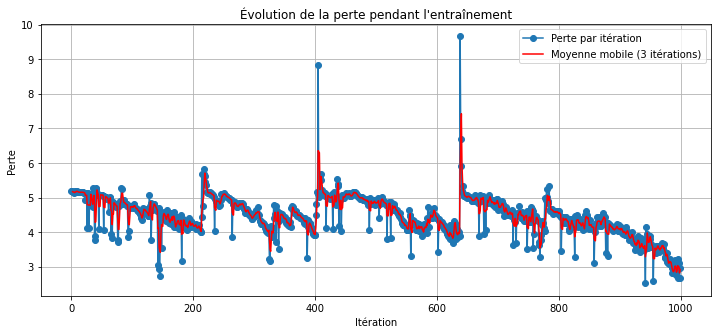

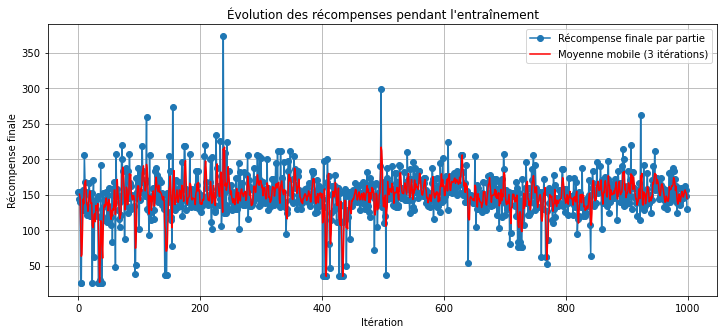

In [ ]:


# Graphique de l'évolution des pertes
plt.figure(figsize=(12, 5))
plt.plot(training_losses, marker='o', label='Perte par itération')
plt.plot(pd.Series(training_losses).rolling(20).mean(), label='Moyenne mobile (3 itérations)', color='red')
plt.xlabel("Itération")
plt.ylabel("Perte")
plt.title("Évolution de la perte pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.show()

# Graphique de l'évolution des récompenses finales
plt.figure(figsize=(12, 5))
plt.plot(training_rewards, marker='o', label='Récompense finale par partie')
plt.plot(pd.Series(training_rewards).rolling(20).mean(), label='Moyenne mobile (3 itérations)', color='red')
plt.xlabel("Itération")
plt.ylabel("Récompense finale")
plt.title("Évolution des récompenses pendant l'entraînement")
plt.legend()
plt.grid(True)
plt.show()


In [11]:



network = SimpleAlphaZeroNet()
network.load_state_dict(torch.load("alpha_zero_model1.pt", map_location=torch.device("cpu")))
network.eval()

agent.name= "AlphaGo"
random_agent.name = "Random"

# Evaluate
results = evaluate_agent(agent, random_agent, num_games=50, render=False)
print("Résultats:", results)

AlphaGo vs Random:   0%|          | 0/50 [00:00<?, ?it/s]

Résultats: {'wins': 22, 'losses': 27, 'draws': 1, 'win_rate': 0.44, 'avg_reward': 143.96}
